In [2]:
%matplotlib qt
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import mne 


In [3]:
# prvi ispitanik svih 24 sesije - snimaka
ispitanici = scipy.io.loadmat(r'SEED-IV\eeg_raw_data\eeg_raw_data\1\1_20160518.mat') #recnik

In [4]:
# TEST BLOK

ispitanicii = list(ispitanici.keys())
# samo prvi snimak od 24 iz prve sesije
ispitanici['cz_eeg1'].shape #matrica (62,33601)
ispitanik1 = ispitanici['cz_eeg1']
ispitanik1[1,:].shape


(33601,)

In [5]:
# funkcija koja pravi mne struktura za jednog ispitanika i jedan video
def mne_struktura(key):
    n_channels = 62
    sampling_freq = 200  # in Hertz
    info = mne.create_info(n_channels, sfreq=sampling_freq)
    ch_names = ["Fp1", "Fpz", "Fp2", "AF3", "AF4", "F7", "F5", "F3", "F1", "Fz", "F2", "F4", "F6", "F8", "FT7", "FC5", "FC3", "FC1", "FCz", "FC2", "FC4", "FC6", "FT8", "T7", "C5", "C3", "C1", "Cz", "C2", "C4", "C6", "T8", "TP7", "CP5", "CP3", "CP1", "CPz", "CP2", "CP4", "CP6", "TP8", "P7", "P5", "P3", "P1", "Pz", "P2", "P4", "P6", "P8", "PO7", "PO5", "PO3", "POz", "PO4", "PO6", "PO8", "CB1", "O1", "Oz", "O2", "CB2"]
    ch_types = ["eeg"]*62
    info = mne.create_info(ch_names, ch_types=ch_types, sfreq=sampling_freq)
    simulated_raw = mne.io.RawArray(ispitanici[key]/1e6, info)
    eeg = simulated_raw
    return eeg


Creating RawArray with float64 data, n_channels=62, n_times=33601
    Range : 0 ... 33600 =      0.000 ...   168.000 secs
Ready.


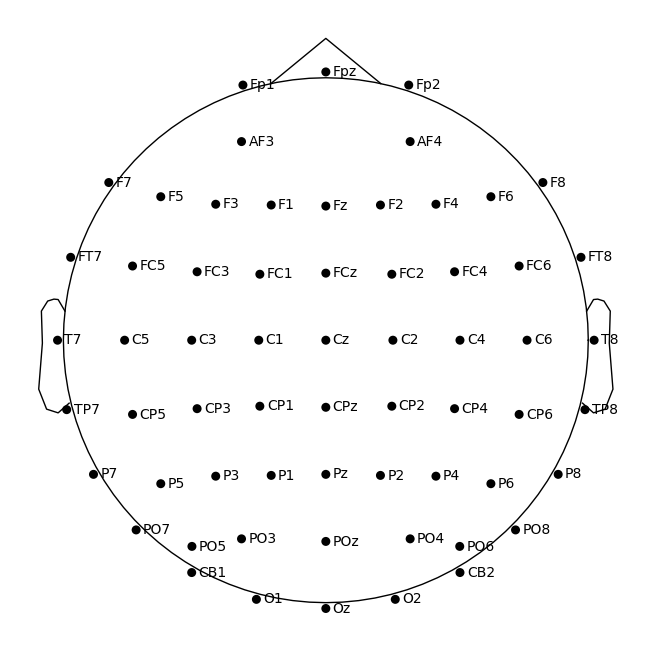

In [6]:
# proba za montazu cz_eeg1
eeg = mne_struktura('cz_eeg1')
montage = mne.channels.read_custom_montage(r'SEED-IV\channel_62_pos.locs')
eeg.set_montage(montage)
mne.viz.plot_montage(montage)

In [7]:
def izdvajanje_kanala(ispitanici,br):
    kanal = []
    for key in  ispitanici.keys():
        if key.startswith('cz_eeg'):
            kanal = np.concatenate((kanal,ispitanici[key][br,:]))
    return kanal


In [8]:
# lista od 62 elementa - svaki elem prestavlja snimak eeg-a sa odredjenog kanala za svih 24 trial-a prve sesije za jednog ispitanika
kanali = []
for i in range(62):
    kanal = izdvajanje_kanala(ispitanici,i)
    kanali.append(kanal)
    
# lista -> ndarray (62, 687024)
kanali = np.array(kanali)
kanali.shape



(62, 687024)

In [9]:
# SREDNJA VREDNOST
sr_vr = []
for i in range(62):
    sr_vr.append(np.mean(kanali[i]))

# srednja vrednost izracunata za svaki kanal za 24 snimanja
srednja_vrednost = np.array(sr_vr)

# STANDARDNA DEVIJACIJA
st_dev = []
for i in range(62):
    st_dev.append(np.std(kanali[i]))

# standardna devojacija izracunata za svaki kanal za 24 snimanja
standardna_devijacija = np.array(st_dev)



In [ ]:
# pravljenje liste svih eeg signala - mne strukture - za 1 ispitanika i 24 videa prve sesije
def ispitanik1_24(ispitanici):
    svi = []
    for i in range(1,25):
        temp = mne_struktura('cz_eeg' + str(i))
        montage = mne.channels.read_custom_montage(r'SEED-IV\channel_62_pos.locs')
        temp.set_montage(montage)
        svi.append(temp)
           
    return svi

lista_eeg_24 = ispitanik1_24(ispitanici)

In [11]:
# filtriranje signala - koristan deo eeg signala 0.5-45HZ - otklanjanje bazne linije i aftefakta mreze
def filtriranje(ispitanici):
    svi = []

    for i in range(1,25):
        svi.append(mne_struktura('cz_eeg' + str(i)).copy().filter(0.5, 45, 'eeg'))
           
    return svi

In [ ]:
#lista svih filtriranih eeg signala za 24 videa - 1 ispitanik
lista_eeg_24_filt = filtriranje(ispitanici)

In [182]:
#SLIKE - filtrirani

filt = lista_eeg_24_filt[0]

plt.figure()
plt.plot(filt.times[200*76:200*83], filt.get_data()[5, 200*76:200*83] * 1e6, 'k', linewidth = 0.7) 
plt.axhline(y=0, color='r', linestyle='-', linewidth=1) 
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (μV)')
plt.title('Channel F7 - filtered - [0.5,45]Hz')
plt.grid(True)
plt.ylim(-52, 100)
#plt.savefig('filtrirani.png', dpi=300)  
plt.show()

In [183]:
# RAW

raw1 = lista_eeg_24[0]

plt.figure()
plt.plot(raw1.times[200*76:200*83], raw1.get_data()[5, 200*76:200*83] * 1e6, 'k', linewidth = 0.7)  
plt.axhline(y=0, color='r', linestyle='-', linewidth=1)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (μV)')
plt.grid(True) 
plt.title('Channel F7 - raw')
plt.ylim(-52, 100)

#plt.savefig('filtrirani.png', dpi=300)  
plt.show()


In [ ]:
# ica - probaj kod kuce ako treba - NE RADI  
raw = lista_eeg_24_filt[0]
ica = mne.preprocessing.ICA(n_components=20, random_state=97, method='fastica')
ica.fit(raw)

# Create a new Raw object for the synthetic EOG channel
eog_channels = raw.copy().pick_channels(['Fp1', 'Fp2','Fpz']).get_data().mean(axis=0)
info = mne.create_info(['EOG'], raw.info['sfreq'], ch_types=['eog'])
synthetic_eog = mne.io.RawArray(eog_channels[np.newaxis, :], info)

# Remove the existing EOG channel from the raw data

# Add the synthetic EOG channel to the raw data
raw.add_channels([synthetic_eog], force_update_info=True)

eog_inds, scores = ica.find_bads_eog(raw)
ica.exclude = eog_inds

raw_clean = ica.apply(raw.copy())
raw_clean.drop_channels(['EOG'])


raw_clean.plot(n_channels=15, duration=10)
plt.show()

In [158]:
# SLIKE - pokreti ociju

#cz_eeg1 filtrirani
selected = ["Fp1", "Fpz", "Fp2", "AF3","AF4", "Fz", "F5", "F3","F1", "F7","FC5","FC3","FC1" ]
filt.plot(picks=selected, duration=7, start = 15)
plt.show()
# Save the plot to a file
#plt.savefig('eeg_channel_1_pokret_ociju.png', dpi=300)  # Save the plot as a PNG file with 300 dpi resolution




Channels marked as bad:
['Fp1', 'Fpz', 'Fp2', 'AF3', 'AF4', 'Fz', 'F5', 'F3', 'F1', 'F7', 'FC5', 'FC3', 'FC1', 'Fp1', 'Fpz', 'Fp2', 'AF3', 'AF4', 'Fz', 'F5', 'F3', 'F1', 'F7', 'FC5', 'FC3', 'FC1']


In [196]:
# ANALIZA LOSIH KANALA
#sumoviti kanali - dodavanje
filt.info["bads"].extend(["Fp1", "Fpz", "Fp2", "AF3","AF4", "Fz", "F5", "F3","F1", "F7","FC5","FC3","FC1" ])  

#sumoviti kanali - interpoliranje
losilosi = ["Fp1", "Fpz", "Fp2", "AF3","AF4",]
eeg_data_interp = filt.copy().interpolate_bads(reset_bads=True)
eeg_data_interp.plot(picks = losilosi, duration = 10, start = 18)
filt.plot(picks = selected, duration = 5, start = 18)

channel_name = 'Fz'  

fig, axes = plt.subplots(5, 1, figsize=(15, 10))

axes[0].plot(eeg_data_interp.times[200 * 17:200 * 27], eeg_data_interp.get_data()[0,200 * 17:200 * 27] * 1e6, 'k', linewidth = 0.7)
axes[0].set_ylim(-70, 70)

axes[1].plot(eeg_data_interp.times[200 * 17:200 * 27], eeg_data_interp.get_data()[1, 200 * 17:200 * 27] * 1e6, 'k', linewidth = 0.7)
axes[1].set_ylim(-70, 70)

axes[2].plot(eeg_data_interp.times[200 * 17:200 * 27], eeg_data_interp.get_data()[2, 200 * 17:200 * 27] * 1e6, 'k', linewidth = 0.7)
axes[2].set_ylim(-70, 70)

axes[3].plot(eeg_data_interp.times[200 * 17:200 * 27], eeg_data_interp.get_data()[3, 200 * 17:200 * 27] * 1e6, 'k', linewidth = 0.7)
axes[3].set_ylim(-70, 70)

axes[4].plot(eeg_data_interp.times[200 * 17:200 * 27], eeg_data_interp.get_data()[4,200 * 17:200 * 27] * 1e6, 'k', linewidth = 0.7)
axes[4].set_ylim(-70, 70)

plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

Setting channel interpolation method to {'eeg': 'spline'}.


Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 49 sensor positions
Interpolating 13 sensors


Channels marked as bad:
none
Channels marked as bad:
none


In [ ]:
# za cz_eeg1: alfa - 8-15, beta - 16 - 31, gamma > 32, teta - 4-7

new_selected = ["Fp1", "Fpz", "Fp2", "AF3"]
eeg_alfa = eeg_data_interp.copy().filter(8, 15, 'eeg')
eeg_beta = eeg_data_interp.copy().filter(16, 31, 'eeg')
eeg_gamma = eeg_data_interp.copy().filter(32, 45, 'eeg')
eeg_teta = eeg_data_interp.copy().filter(4, 7, 'eeg')


channel_name = 'Fz'  

fig, axes = plt.subplots(4, 1, figsize=(15, 10))

axes[0].plot(eeg_alfa.times[:200 * 10], eeg_alfa.get_data()[0, :200 * 10] * 1e6, 'k', linewidth = 0.7)
axes[0].set_title('Alpha - Fz')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude (μV)')

axes[1].plot(eeg_beta.times[:200 * 10], eeg_beta.get_data()[0, :200 * 10] * 1e6, 'k', linewidth = 0.7)
axes[1].set_title('Beta - Fz')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Amplitude (μV)')

axes[2].plot(eeg_gamma.times[:200 * 10], eeg_gamma.get_data()[0, :200 * 10] * 1e6, 'k', linewidth = 0.7)
axes[2].set_title('Gamma - Fz')
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('Amplitude (μV)')

axes[3].plot(eeg_teta.times[:200 * 10], eeg_teta.get_data()[0, :200 * 10] * 1e6, 'k', linewidth = 0.7)
axes[3].set_title('Theta - Fz')
axes[3].set_xlabel('Time (s)')
axes[3].set_ylabel('Amplitude (μV)')

plt.subplots_adjust(wspace=0.3, hspace=1)
plt.show()

In [82]:

#trajanje sesije - za cz_
Ts = 1/200;
[ kanali , semplovi_signala ] = ispitanik1.shape
vreme_trajanja = Ts*semplovi_signala # u sekindama
trajanje_prozora = 6
vreme_trajanja 

 

168.005

In [19]:
# PEAK TO PEAK - za jedan kanal
[poz_pik, mag_pik] = mne.preprocessing.peak_finder(ispitanik1[1,:]) #90
Ts = 1/200
prvo = Ts*poz_pik[1:]
drugo = Ts*poz_pik[0:-1]
razlika = prvo - drugo
PTP = np.mean(razlika)
PTP
# drugo = mag_pik[0:-1]
# prvo = mag_pik[1:]
# razlika = prvo - drugo
# usrednjena_mag = np.mean(razlika)



Found 90 significant peaks


1.8847191011235955

In [20]:
vreme = np.linspace(0,len(ispitanik1[1,:])*Ts,len(ispitanik1[1,:]))
plt.plot(vreme[vreme<30], ispitanik1[1,:][vreme<30])
plt.show()

Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
